In [14]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy


# Load SpaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Load SBERT model for embeddings
embedder = SentenceTransformer("all-mpnet-base-v2")

def clean_text(text):
    """Preprocess text and extract meaningful phrases."""
    if not isinstance(text, str):  # Handle NaN or non-string values
        return ""

    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers

    # Process text with SpaCy
    doc = nlp(text)

    # Extract noun phrases instead of just words
    phrases = set()
    for chunk in doc.noun_chunks:
        phrase = chunk.text.strip()
        if len(phrase.split()) > 1:  # Keep only meaningful phrases
            phrases.add(phrase)

    return list(phrases)

def save_embeddings(file_path, phrases_list, phrase_embeddings_list, paper_embeddings):
    """Save extracted phrases and their embeddings to a file, handling variable-length embeddings."""
    
    # Save phrases and embeddings as a compressed `.npz` file
    np.savez_compressed(file_path.replace(".csv", "_embeddings.npz"), 
                        phrases_list=np.array(phrases_list, dtype=object), 
                        phrase_embeddings_list=np.array(phrase_embeddings_list, dtype=object), 
                        paper_embeddings=np.array(paper_embeddings))

    print(f"✅ Embeddings saved to {file_path.replace('.csv', '_embeddings.npz')}")


def extract_themes(text, top_n=5):
    """Extract top thematic phrases from an AI research paper."""
    
    # Step 1: Preprocess the text
    phrases = clean_text(text)
    
    if not phrases:
        return "No meaningful phrases found.", []

    # Step 2: Compute embeddings
    paper_embedding = embedder.encode(text, convert_to_tensor=True)
    phrase_embeddings = embedder.encode(phrases, convert_to_tensor=True)

    # Step 3: Rank phrases by relevance
    relevance_scores = util.pytorch_cos_sim(phrase_embeddings, paper_embedding).squeeze().cpu().numpy()
    sorted_indices = np.argsort(relevance_scores)[::-1]  # Sort by highest relevance

    # Step 4: Select top meaningful phrases
    filtered_phrases = [phrases[i] for i in sorted_indices[:top_n]]

    # Step 5: Generate theme statement
    # theme_statement = f"🔹 The paper explores themes of: {', '.join(filtered_phrases)}."
    
    return filtered_phrases
    # return theme_statement, filtered_phrases

def process_dataset(file_path, save_embeds=True):  # Renamed boolean flag
    """Run theme extraction for all abstracts in a dataset."""
    
    # Load dataset
    df = pd.read_csv(file_path)

    # Ensure there's an 'abstract' column
    if 'Abstract' not in df.columns:
        raise ValueError("Dataset must contain an 'abstract' column.")

    # Create empty lists to store results
    # theme_statements = []
    key_phrases_list = []
    # all_paper_embeddings = []
    all_phrase_embeddings = []

    # Process each abstract
    for idx, row in df.iterrows():
        text = row["Abstract"]
        
        # theme_statement, key_phrases = extract_themes(text)
        key_phrases = extract_themes(text)

        # Store extracted themes
        # theme_statements.append(theme_statement)
        key_phrases_list.append(", ".join(key_phrases))  # Store as a string for CSV

        # Store embeddings if required
        if save_embeds:
            # paper_embedding = embedder.encode(text, convert_to_numpy=True)
            phrase_embeddings = embedder.encode(key_phrases, convert_to_numpy=True)

            # all_paper_embeddings.append(paper_embedding)
            all_phrase_embeddings.append(phrase_embeddings)

    # Add extracted themes to DataFrame
    # df["extracted_themes"] = theme_statements
    df["key_phrases"] = key_phrases_list

    # Save extracted themes to a new CSV
    output_file = file_path.replace(".csv", "_with_themes.csv")
    df.to_csv(output_file, index=False)
    print(f"\n✅ Processed dataset saved to {output_file}")

    # Save embeddings separately if needed
    if save_embeds:
        save_embeddings(file_path, key_phrases_list, all_phrase_embeddings, all_paper_embeddings)
        save_embeddings(file_path, key_phrases_list, all_phrase_embeddings)

main_directory = os.path.join('/', *os.getcwd().split('/')[:-1])
data_folder = os.path.join(main_directory, 'data')

# Load AI research papers dataset
# df = pd.read_csv(f"{data_folder}/ai_research_papers_last_10_years.csv")
# Example: Process dataset containing AI research abstracts
process_dataset(f"{data_folder}/filtered_arxiv_AI_papers.csv")

KeyboardInterrupt: 

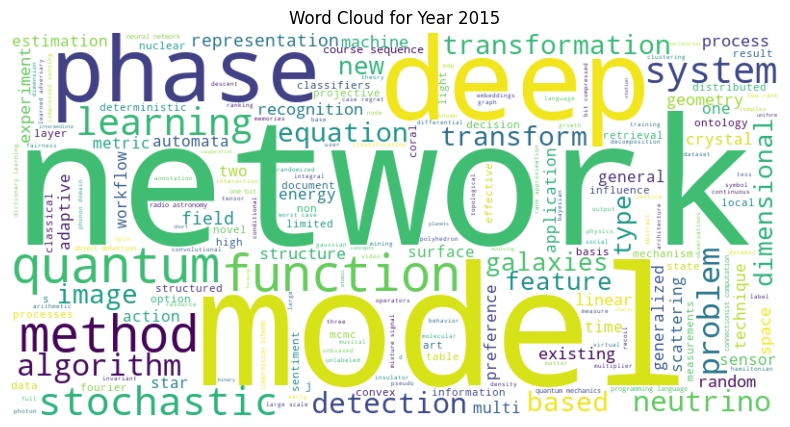

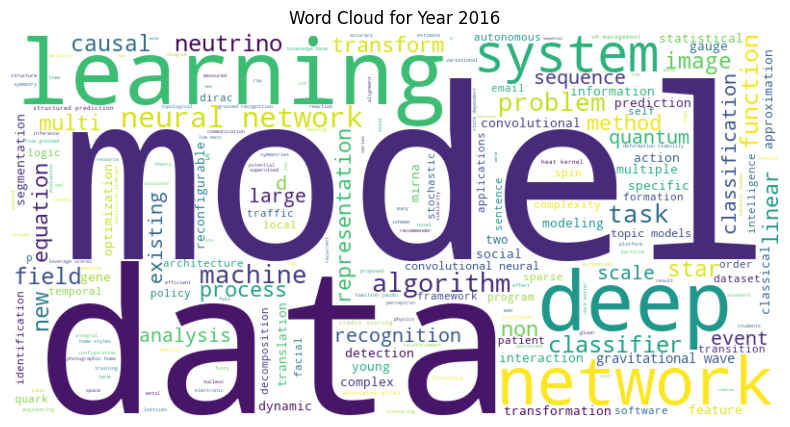

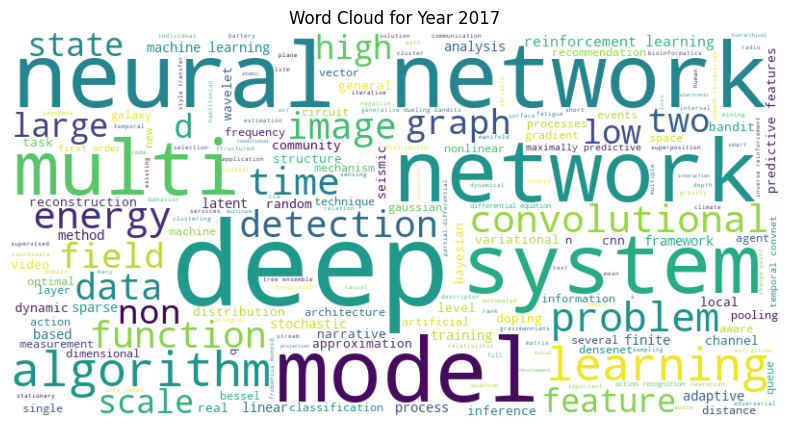

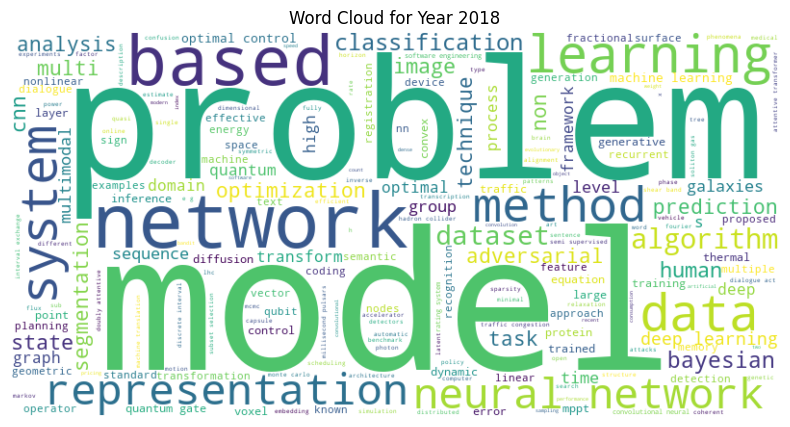

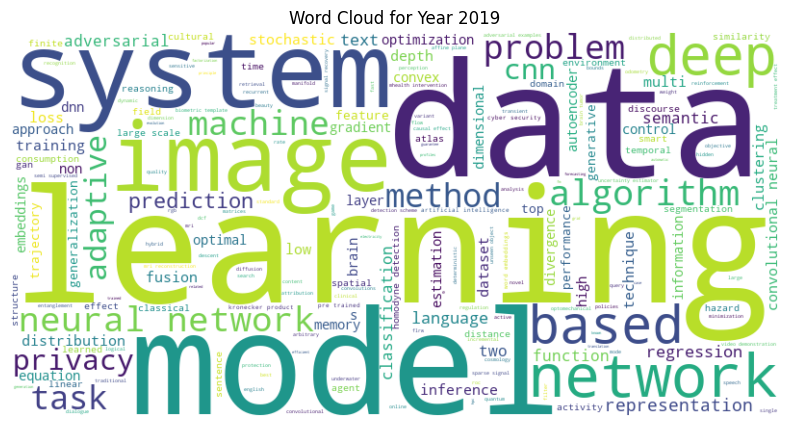

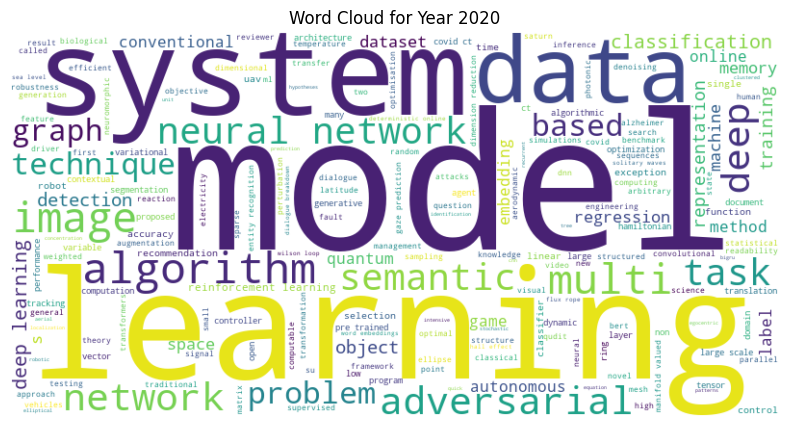

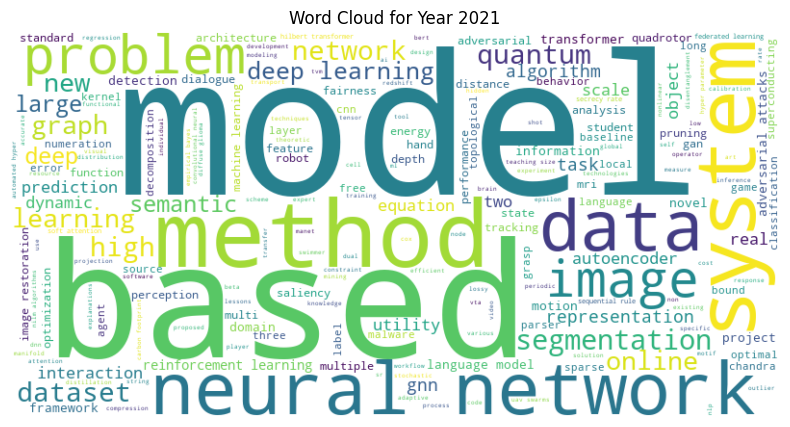

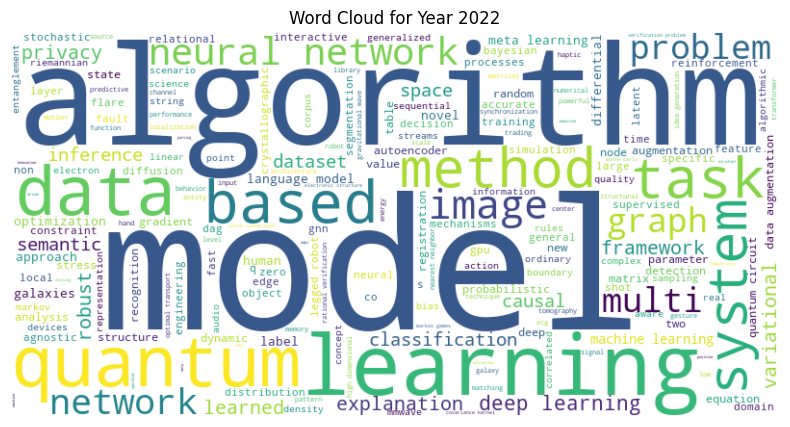

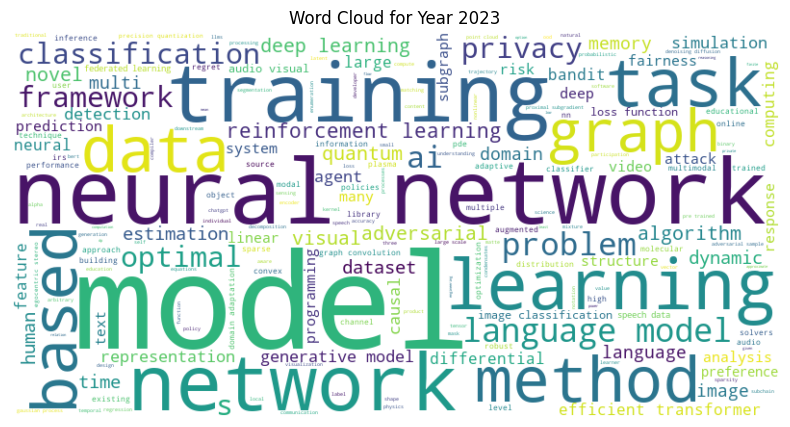

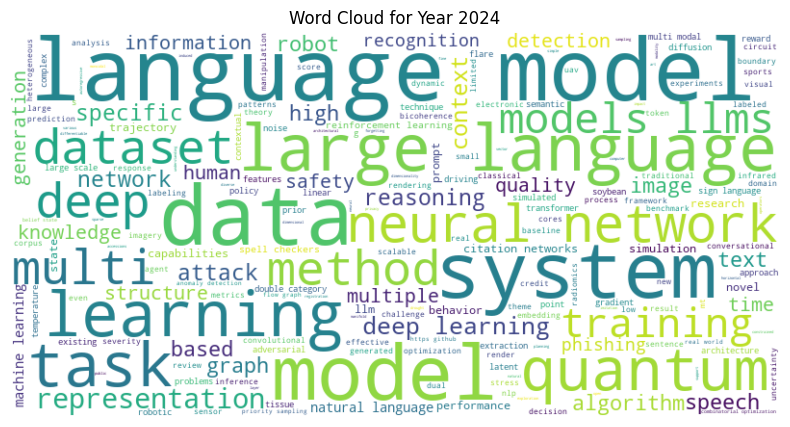

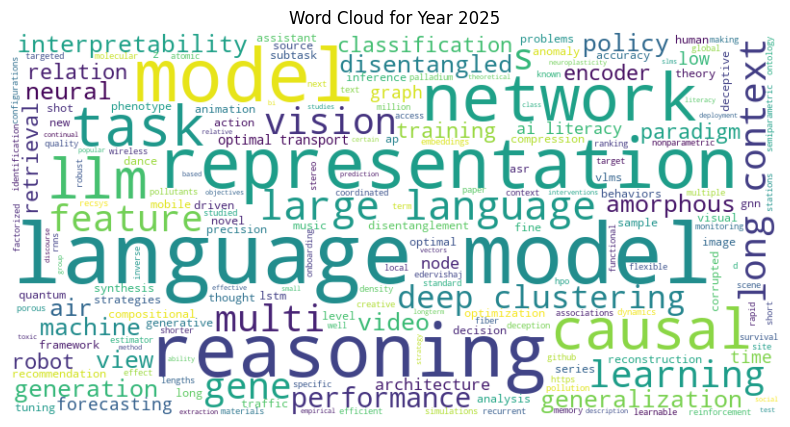

In [11]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(f"{data_folder}/ai_research_papers_balanced_10_years_with_themes.csv")

# Ensure there's a 'published_date' column
if 'published_date' not in df.columns:
    raise ValueError("Dataset must contain a 'published_date' column.")

# Extract the year from the 'published_date' column
df['year'] = pd.to_datetime(df['published_date']).dt.year

# Generate and plot word clouds for each year
years = df['year'].unique()
for year in sorted(years):
    year_data = df[df['year'] == year]
    text = ' '.join(year_data['key_phrases'].dropna().tolist())
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Year {year}')
    plt.show()

In [10]:
!pip3 install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.2 MB/s eta 0:00:00
